In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=10000)

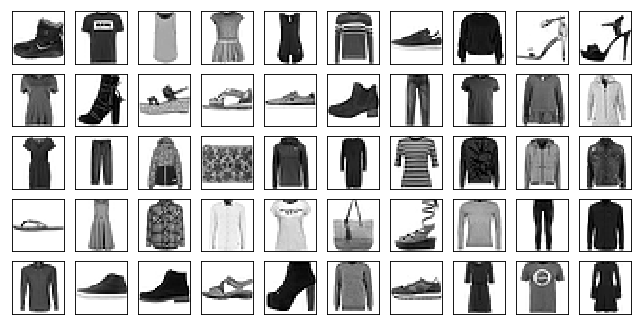

In [3]:
images = fashion_mnist_plotdata()
plot_fashion_mnist(images, (5, 10))

In [61]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [122]:
def train(epoch, models):
    loss_stats = [np.array([])] * len(models)
    
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        m = 0
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
            loss_stats[m] = np.append(loss_stats[m], model._loss.item())
            m += 1            
            
            
        if batch_idx % 200 == 0:
            print_stats(models, train_loader, epoch, batch_idx, data, train_size)
            
    else:
        batch_idx += 1
        print_stats(models, train_loader, epoch, batch_idx, data, train_size)
    
    epoch_loss = [np.mean(x) for x in loss_stats]    
    return epoch_loss
       
        
def print_stats(models, train_loader, epoch, batch_idx, data, train_size):
    line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
    losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
    print(line + losses)
        

In [123]:
models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]

In [124]:
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)

In [125]:
epoch_train_loss = []
train_acc_stats = []

In [126]:
for epoch in range(1, 11):
    for model in models:
        model.train()
    epoch_loss_val = train(epoch, models)
    epoch_train_loss.append(epoch_loss_val)
    
    for model in models:
        model.eval()
    test(models, valid_loader)

Train Epoch: 1 [0/50000 (0%)]	Losses 0: 2.301903 1: 2.299978 2: 2.308571 3: 2.332817
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 0.772470 1: 1.232332 2: 0.809655 3: 1.276734
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 0.488456 1: 0.582774 2: 0.476457 3: 0.613038
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.510708 1: 0.662945 2: 0.496875 3: 0.698787
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.599392 1: 0.617282 2: 0.618485 3: 0.616960
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.361834 1: 0.378442 2: 0.354054 3: 0.328251
Test set:
0: Loss: 0.4696	Accuracy: 8307/10000 (83%)
1: Loss: 0.4429	Accuracy: 8421/10000 (84%)
2: Loss: 0.4719	Accuracy: 8306/10000 (83%)
3: Loss: 0.4383	Accuracy: 8458/10000 (84%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.545192 1: 0.533508 2: 0.535897 3: 0.517981
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.470422 1: 0.408401 2: 0.478061 3: 0.474873
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.426093 1: 0.369833 2: 0.437279 3: 0.405438
Train Epoch: 2 [

In [148]:
epoch_train_loss_np = np.array(epoch_loss)



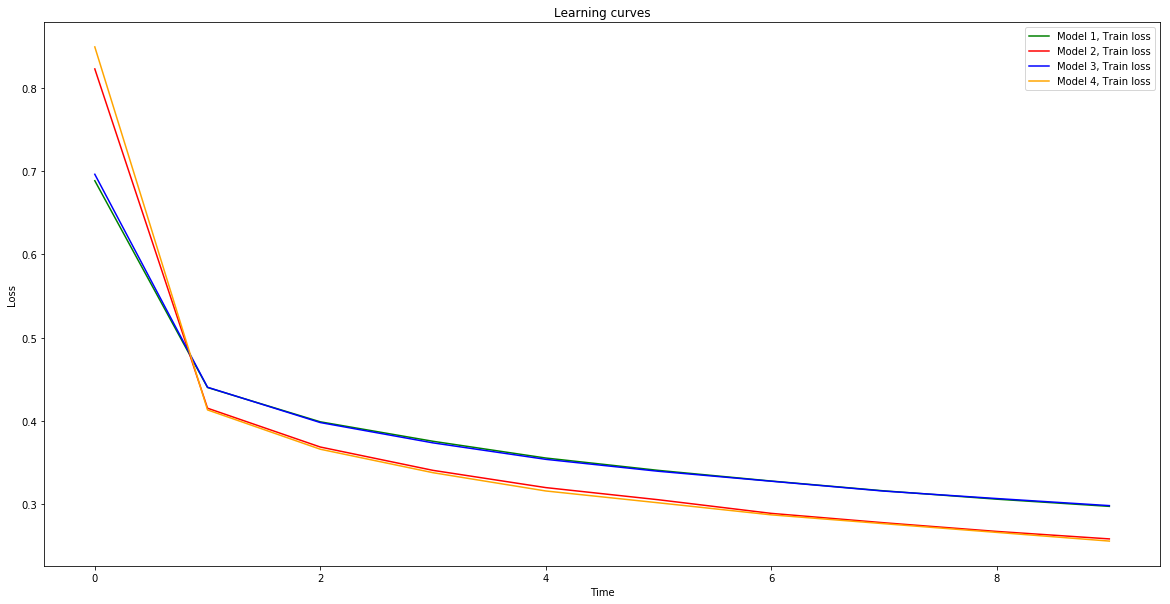

In [149]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.set_title("Learning curves")
plt.plot(epoch_loss_np.T[0], color='green', label='Model 1, Train loss')
plt.plot(epoch_loss_np.T[1], color='red', label='Model 2, Train loss')
plt.plot(epoch_loss_np.T[2], color='blue', label='Model 3, Train loss')
plt.plot(epoch_loss_np.T[3], color='orange', label='Model 4, Train loss')

ax.set_ylabel("Loss")
ax.set_xlabel("Time")
ax.legend()